### Loading rpy2 environment for simultaneous R and Python execution and data exchange between them

In [1]:
import rpy2.rinterface
from IPython.display import Image
%load_ext rpy2.ipython
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'

D:\programs\Python37\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


### Loading necessary packages for R

In [2]:
%%R
library(vars)
library(glue)
library(dynlm)

R[write to console]: Loading required package: MASS

R[write to console]: Loading required package: strucchange

R[write to console]: Loading required package: zoo

R[write to console]: 
Attaching package: 'zoo'


R[write to console]: The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


R[write to console]: Loading required package: sandwich

R[write to console]: Loading required package: urca

R[write to console]: Loading required package: lmtest



### Loading necessary packages for python

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

### Loading data and performing data manipulation

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/htdanil/referenced_to_github/master/G0003%20data_ex1.csv')

#------------------------------------------------------------
#defining date index for the dataframe
#------------------------------------------------------------
index = pd.date_range('2000Q1', periods=df.shape[0], freq='Q')
df.set_index(index,inplace=True)

#---------------------------------------------------------------------
#log conversion and trend variables creation
#---------------------------------------------------------------------
df[['lg','lgc','lgi','lt','ly']] = np.log(df[['g','gc','gi','t','y']])
# df[['lg','lgc','lgi','lt','ly']] = df[['g','gc','gi','t','y']]
df['trend'] = range(1,df.shape[0]+1)
df['trend_2'] = np.power(df['trend'],2)

#---------------------------------------------------------------------
#Pushing dataframe to R environment
#---------------------------------------------------------------------
%Rpush df

D:\programs\Python37\lib\site-packages\rpy2\robjects\pandas2ri.py:63: UserWarning: Error while trying to convert the column "quarter". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))


In [5]:
%%R
#---------------------------------------------------------------------
#Creating time series (ts) objects in R
#---------------------------------------------------------------------
lg   <- ts(df$lg, start = c(2000,1), frequency = 4)
lgc  <- ts(df$lgc, start = c(2000,1), frequency = 4)
lgi  <- ts(df$lgi, start = c(2000,1), frequency = 4)
ltax <- ts(df$lt, start = c(2000,1), frequency = 4)
ly   <- ts(df$ly, start = c(2000,1), frequency = 4)

trend   <- ts(df$trend, start = c(2000,1), frequency = 4)
trend_2 <- ts(df$trend_2, start = c(2000,1), frequency = 4)

---

## VAR models
  
Lag selection is done with AIC(n) criteria with max lag of 6 with both intercept and trend components. The result shows that lag selection should be of 2.

---

In [6]:
%%R
data4var <- cbind(lg,ly,ltax)
print(VARselect(data4var, lag.max = 6, type = 'both'))

$selection
AIC(n)  HQ(n)  SC(n) FPE(n) 
     2      1      1      2 

$criteria
                   1             2             3             4             5
AIC(n) -1.529716e+01 -1.535099e+01 -1.524254e+01 -1.518768e+01 -1.524764e+01
HQ(n)  -1.510185e+01 -1.503848e+01 -1.481285e+01 -1.464080e+01 -1.458357e+01
SC(n)  -1.480358e+01 -1.456125e+01 -1.415665e+01 -1.380563e+01 -1.356944e+01
FPE(n)  2.274514e-07  2.160939e-07  2.421896e-07  2.583532e-07  2.470574e-07
                   6
AIC(n) -1.501982e+01
HQ(n)  -1.423857e+01
SC(n)  -1.304547e+01
FPE(n)  3.172465e-07



In [7]:
%%R
#---------------------------------------------------------------------
# VAR model is constructed for log(g), log(y) and log(tax) with lag selection of 2
# with with both intercept and trend components.
#---------------------------------------------------------------------
model_var <- VAR(data4var, p = 2, type = 'both')
summary(model_var)


VAR Estimation Results:
Endogenous variables: lg, ly, ltax 
Deterministic variables: both 
Sample size: 71 
Log Likelihood: 271.432 
Roots of the characteristic polynomial:
0.9558 0.7042 0.4175 0.4175 0.294 0.216
Call:
VAR(y = data4var, p = 2, type = "both")


Estimation results for equation lg: 
lg = lg.l1 + ly.l1 + ltax.l1 + lg.l2 + ly.l2 + ltax.l2 + const + trend 

         Estimate Std. Error t value Pr(>|t|)  
lg.l1    0.284800   0.124200   2.293   0.0252 *
ly.l1   -1.303834   0.950483  -1.372   0.1750  
ltax.l1 -0.029883   0.030277  -0.987   0.3274  
lg.l2    0.073538   0.123935   0.593   0.5551  
ly.l2    2.058678   0.939570   2.191   0.0322 *
ltax.l2  0.018680   0.030250   0.618   0.5391  
const   -1.909665   1.766577  -1.081   0.2838  
trend   -0.003428   0.001739  -1.972   0.0530 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Residual standard error: 0.09071 on 63 degrees of freedom
Multiple R-Squared: 0.6854,	Adjusted R-squared: 0.6505 
F-statistic: 

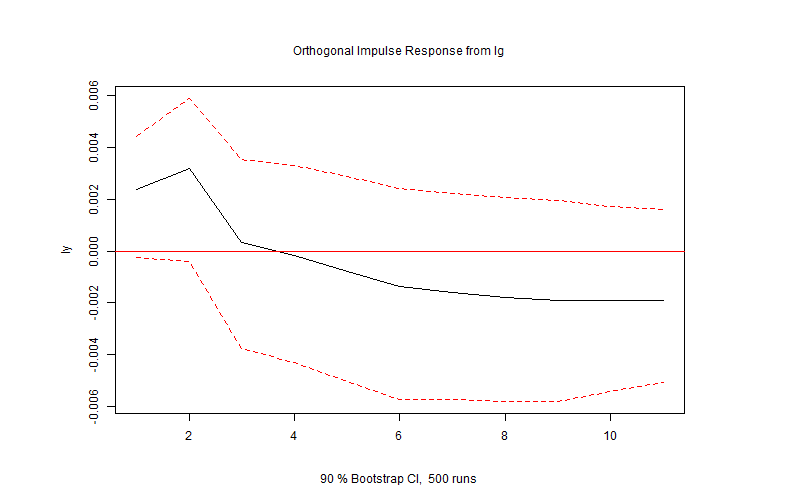

In [8]:
%%R -w 800 -h 500

#---------------------------------------------------------------------
# Constructing impulse responses of log(y) due to shock in log(g)
#---------------------------------------------------------------------
irf <- irf(model_var, 
            impulse = 'lg', 
            response = 'ly', 
            n.ahead = 10, #optional (default: 10)
            boot = TRUE, #optional (default: TRUE)
            runs = 500, #optional (default:100)
            ortho = TRUE, #optional (default: TRUE)
            ci = 0.9) #optional (default: 0.95)

plot(irf)

---

### Repeating similar procedure for log(gc), log(y), log(tax) and log(gi), log(y), log(tax) models.

---

AIC(n)  HQ(n)  SC(n) FPE(n) 
     2      1      1      2 


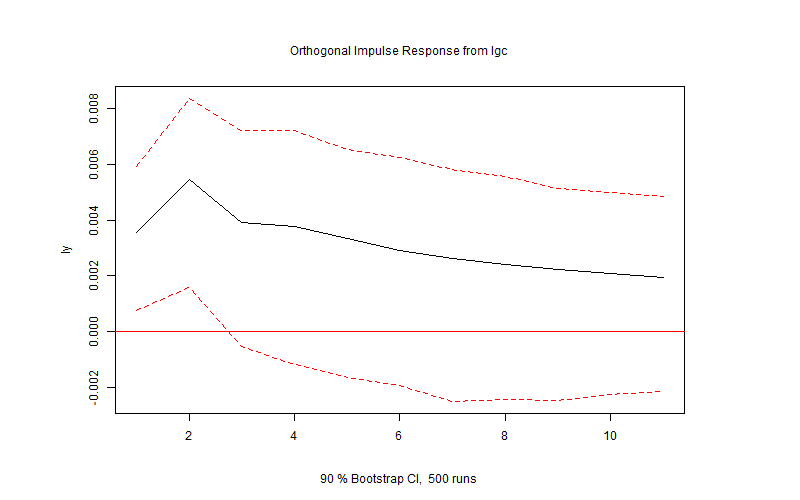

In [9]:
%%R -w 800 -h 500
data4var <- cbind(lgc,ly,ltax)
print(VARselect(data4var, lag.max = 6, type = 'both')$selection)
model_var <- VAR(data4var, p = 2, type = 'both')
irf <- irf(model_var, 
            impulse = 'lgc', 
            response = 'ly', 
            n.ahead = 10, #optional (default: 10)
            boot = TRUE, #optional (default: TRUE)
            runs = 500, #optional (default:100)
            ortho = TRUE, #optional (default: TRUE)
            ci = 0.9) #optional (default: 0.95)
plot(irf)

AIC(n)  HQ(n)  SC(n) FPE(n) 
     1      1      1      1 


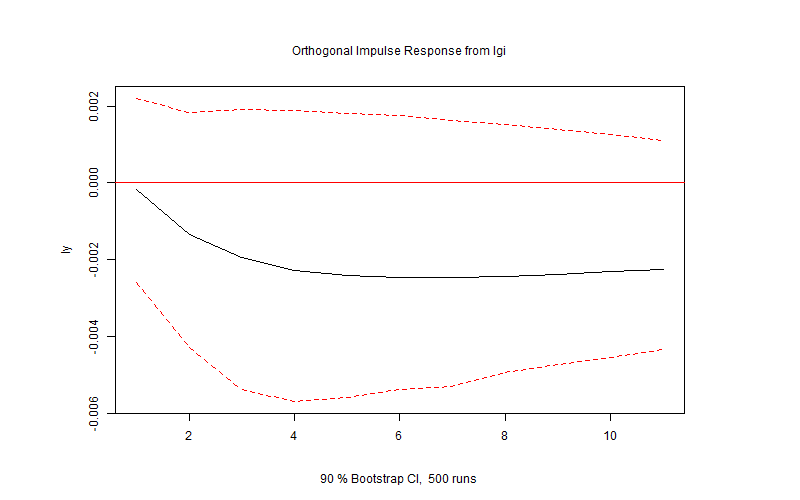

In [10]:
%%R -w 800 -h 500
data4var <- cbind(lgi,ly,ltax)
print(VARselect(data4var, lag.max = 6, type = 'both')$selection)
model_var <- VAR(data4var, p = 1, type = 'both')
irf <- irf(model_var, 
            impulse = 'lgi', 
            response = 'ly', 
            n.ahead = 10, #optional (default: 10)
            boot = TRUE, #optional (default: TRUE)
            runs = 500, #optional (default:100)
            ortho = TRUE, #optional (default: TRUE)
            ci = 0.9) #optional (default: 0.95)

plot(irf)

---

### Local Projection estimation of impulse responses

First we have to identify shocks for government spending (lg), government consumption (lgc), and government investment (lgi). This is done with OLS (the first equation of SVAR with ordering) and the number of lags is based on the lag selection criteria of VAR.

---

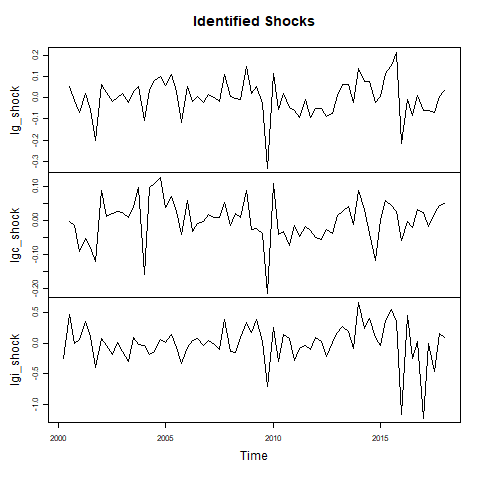

In [11]:
%%R
lg_shock <- dynlm(lg ~ L(lg,1:2) + L(ly,1:2) + L(ltax,1:2) + trend(lg, scale = FALSE))$residuals #2 lags
lgc_shock <- dynlm(lgc ~ L(lgc,1:2) + L(ly,1:2) + L(ltax,1:2) + trend(lg, scale = FALSE))$residuals #2 lags
lgi_shock <- dynlm(lgi ~ L(lgi,1) + L(ly,1) + L(ltax,1) + trend(lg, scale = FALSE))$residuals #1 lag

#plotting identified shocks
plot(cbind(lg_shock,lgc_shock,lgi_shock), main='Identified Shocks')

In [12]:
%%R
#----------------------------------------------------------
# creating empty variable
#----------------------------------------------------------
lg_coef <- NULL
lg_se <- NULL

#----------------------------------------------------------
# setting horizon to 20
#----------------------------------------------------------
horizon = 20

#----------------------------------------------------------
# loop for constructing series of impulse responses 
# and standard error for confidence interval
#----------------------------------------------------------
for (i in seq(0,horizon,1)){
    reg <- summary(dynlm(lag(ly,i) ~ L(lg_shock,0:2) + L(ly,1:2) + L(ltax,1:2) + L(lg,1:2)))
    coef_ <- reg$coefficients['L(lg_shock, 0:2)0','Estimate']
    se_ <- reg$coefficients['L(lg_shock, 0:2)0','Std. Error']
    lg_coef <- c(lg_coef, coef_ )
    lg_se <- c(lg_se, se_)
}

In [13]:
%%R
#----------------------------------------------------------
# Repeating similar process as above
#----------------------------------------------------------

lgc_coef <- NULL
lgc_se <- NULL

for (i in seq(0,horizon,1)){
    reg <- summary(dynlm(lag(ly,i) ~ L(lgc_shock,0:2) + L(ly,1:2) + L(ltax,1:2) + L(lgc,1:2)))
    coef_ <- reg$coefficients['L(lgc_shock, 0:2)0','Estimate']
    se_ <- reg$coefficients['L(lgc_shock, 0:2)0','Std. Error']
    lgc_coef <- c(lgc_coef, coef_ )
    lgc_se <- c(lgc_se, se_)
}

In [14]:
%%R

lgi_coef <- NULL
lgi_se <- NULL

for (i in seq(0,horizon,1)){
    reg <- summary(dynlm(lag(ly,i) ~ L(lgi_shock,0:2) + L(ly,1:2) + L(ltax,1:2) + L(lgi,1:2)))
    coef_ <- reg$coefficients['L(lgi_shock, 0:2)0','Estimate']
    se_ <- reg$coefficients['L(lgi_shock, 0:2)0','Std. Error']
    lgi_coef <- c(lgi_coef, coef_ )
    lgi_se <- c(lgi_se, se_)
}

In [15]:
#----------------------------------------------------------
# exchanging variables from R to Python for graphing
#----------------------------------------------------------
lg_coef = %Rget lg_coef
lgc_coef = %Rget lgc_coef
lgi_coef = %Rget lgi_coef

lg_se = %Rget lg_se
lgc_se = %Rget lgc_se
lgi_se = %Rget lgi_se

Text(0.5, 1.0, 'Local Projection : LOG(GI) --> LOG(Y)')

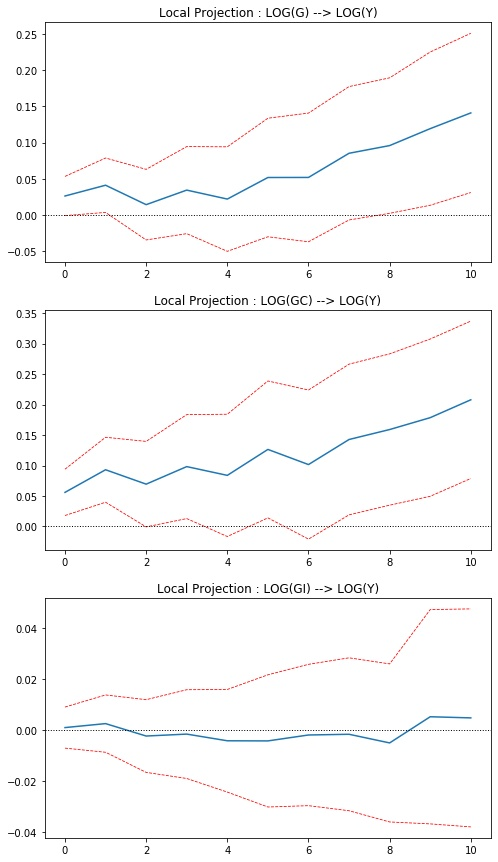

In [16]:
#----------------------------------------------------------
# Graphing of Local Projection impulse responses
#----------------------------------------------------------

fig = plt.figure(figsize=(8,15))
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)

horizon = 11

ax1.plot(lg_coef[:horizon])
ax1.plot((lg_coef + 1.645 * lg_se)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax1.plot((lg_coef - 1.645 * lg_se)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax1.axhline(0, color='black', linestyle=':', linewidth=1)
ax1.set_title('Local Projection : LOG(G) --> LOG(Y)')

ax2.plot(lgc_coef[:horizon])
ax2.plot((lgc_coef + 1.645 * lgc_se)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax2.plot((lgc_coef - 1.645 * lgc_se)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax2.axhline(0, color='black', linestyle=':', linewidth=1)
ax2.set_title('Local Projection : LOG(GC) --> LOG(Y)')

ax3.plot(lgi_coef[:horizon])
ax3.plot((lgi_coef + 1.645 * lgi_se)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax3.plot((lgi_coef - 1.645 * lgi_se)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax3.axhline(0, color='black', linestyle=':', linewidth=1)
ax3.set_title('Local Projection : LOG(GI) --> LOG(Y)')

---
## Using smooth transition function for state-dependent impulse responses

Using GDP growth as $z_{t}$ and smooth transitioning parameter $\delta$ is set to 1.5 i.e. $\delta = 1.5$

$G(z_{t}) = \frac{exp(-\delta z_{t})}{1 + exp(-\delta z_{t})} , \delta >0$

---

D:\programs\Python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'GDP growth rate')

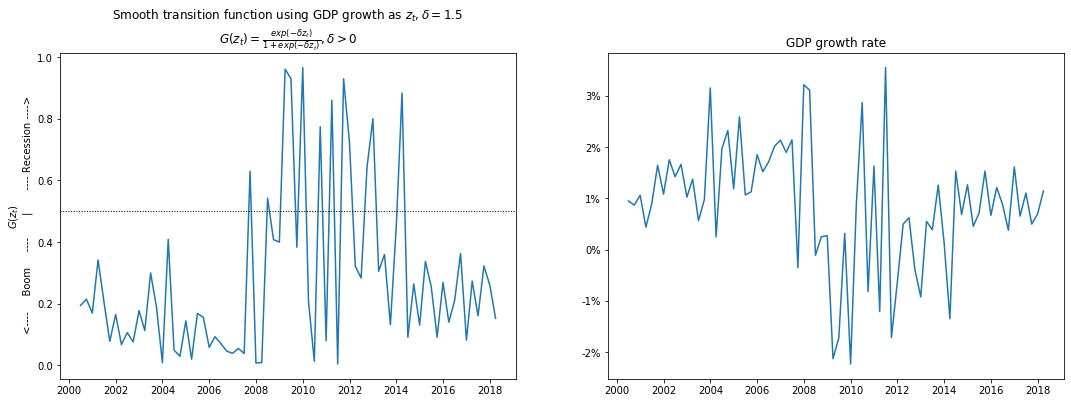

In [17]:
df['y_growth'] = df['ly'].diff()
delta = 1.5
D = np.exp(- delta * df['y_growth'] * 100 )/(1 + np.exp(- delta * df['y_growth'] * 100))

fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.plot(D)
ax1.set_title('Smooth transition function using GDP growth as ' 
          + r'$z_{t}, \delta = 1.5$' 
          + '\n'
          + r'$G(z_{t}) = \frac{exp(-\delta z_{t})}{1 + exp(-\delta z_{t})} , \delta >0$')
ax1.set_ylabel(r'$G(z_{t})$' + '\n' + ' <----     Boom     ----       |       ---- Recession ---->')
ax1.axhline(0.5, color='black', linestyle=':', linewidth=1)

ax2.plot(df['y_growth'])
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax2.set_title('GDP growth rate')

In [18]:
%Rpush D
# %R saveRDS(object = D, file = 'temp/D.rds')

In [19]:
%%R
# D <- readRDS('temp/D.rds')
D <- ts(D, start = c(2000,1), frequency = 4)

lg_shock_D <- D * lg_shock
lg_shock_1_D <- (1-D) * lg_shock

lgc_shock_D <- D * lgc_shock
lgc_shock_1_D <- (1-D) * lgc_shock

lgi_shock_D <- D * lgi_shock
lgi_shock_1_D <- (1-D) * lgi_shock

In [20]:
%%R
#----------------------------------------------------------
# creating empty variables
#----------------------------------------------------------
lg_coef_boom <- NULL
lg_se_boom <- NULL

lg_coef_recession <- NULL
lg_se_recession <- NULL

#----------------------------------------------------------
# setting horizon to 20
#----------------------------------------------------------
horizon = 20

#----------------------------------------------------------
# loop for constructing series of impulse responses 
# and standard error for confidence interval
#----------------------------------------------------------
for (i in seq(0,horizon,1)){
    reg <- summary(dynlm(lag(ly,i) ~ lg_shock_D + lg_shock_1_D + L(lg_shock,1:2) + L(ly,1:2) + L(ltax,1:2) + L(lg,1:2)))
    
    coef_recession <- reg$coefficients['lg_shock_D','Estimate']
    se_recession <- reg$coefficients['lg_shock_D','Std. Error']
    lg_coef_recession <- c(lg_coef_recession, coef_recession )
    lg_se_recession <- c(lg_se_recession, se_recession)
    
    coef_boom <- reg$coefficients['lg_shock_1_D','Estimate']
    se_boom <- reg$coefficients['lg_shock_1_D','Std. Error']
    lg_coef_boom <- c(lg_coef_boom, coef_boom )
    lg_se_boom <- c(lg_se_boom, se_boom)
    
}

In [21]:
%%R

#----------------------------------------------------------
# Repeating the process as above for government consumption
#----------------------------------------------------------

lgc_coef_boom <- NULL
lgc_se_boom <- NULL

lgc_coef_recession <- NULL
lgc_se_recession <- NULL


for (i in seq(0,horizon,1)){
    reg <- summary(dynlm(lag(ly,i) ~ lgc_shock_D + lgc_shock_1_D + L(lgc_shock,1:2) + L(ly,1:2) + L(ltax,1:2) + L(lgc,1:2)))
    
    coef_recession <- reg$coefficients['lgc_shock_D','Estimate']
    se_recession <- reg$coefficients['lgc_shock_D','Std. Error']
    lgc_coef_recession <- c(lgc_coef_recession, coef_recession )
    lgc_se_recession <- c(lgc_se_recession, se_recession)
    
    coef_boom <- reg$coefficients['lgc_shock_1_D','Estimate']
    se_boom <- reg$coefficients['lgc_shock_1_D','Std. Error']
    lgc_coef_boom <- c(lgc_coef_boom, coef_boom )
    lgc_se_boom <- c(lgc_se_boom, se_boom)
    
}

In [22]:
%%R

#----------------------------------------------------------
# Repeating the process as above for government investment
#----------------------------------------------------------
lgi_coef_boom <- NULL
lgi_se_boom <- NULL

lgi_coef_recession <- NULL
lgi_se_recession <- NULL


for (i in seq(0,horizon,1)){
    reg <- summary(dynlm(lag(ly,i) ~ lgi_shock_D + lgi_shock_1_D + L(lgi_shock,1:2) + L(ly,1:2) + L(ltax,1:2) + L(lgi,1:2)))
    
    coef_recession <- reg$coefficients['lgi_shock_D','Estimate']
    se_recession <- reg$coefficients['lgi_shock_D','Std. Error']
    lgi_coef_recession <- c(lgi_coef_recession, coef_recession )
    lgi_se_recession <- c(lgi_se_recession, se_recession)
    
    coef_boom <- reg$coefficients['lgi_shock_1_D','Estimate']
    se_boom <- reg$coefficients['lgi_shock_1_D','Std. Error']
    lgi_coef_boom <- c(lgi_coef_boom, coef_boom )
    lgi_se_boom <- c(lgi_se_boom, se_boom)
    
}

In [23]:
#----------------------------------------------------------
# exchanging variables from R to Python for graphing
#----------------------------------------------------------
lg_coef_boom         = %Rget lg_coef_boom
lg_coef_recession    = %Rget lg_coef_recession
lgc_coef_boom        = %Rget lgc_coef_boom
lgc_coef_recession   = %Rget lgc_coef_recession
lgi_coef_boom        = %Rget lgi_coef_boom
lgi_coef_recession   = %Rget lgi_coef_recession

lg_se_boom         = %Rget lg_se_boom
lg_se_recession    = %Rget lg_se_recession
lgc_se_boom        = %Rget lgc_se_boom
lgc_se_recession   = %Rget lgc_se_recession
lgi_se_boom        = %Rget lgi_se_boom
lgi_se_recession   = %Rget lgi_se_recession

Text(0.5, 1.0, 'Government Investment to GDP, LOG(GI) --> LOG(Y)')

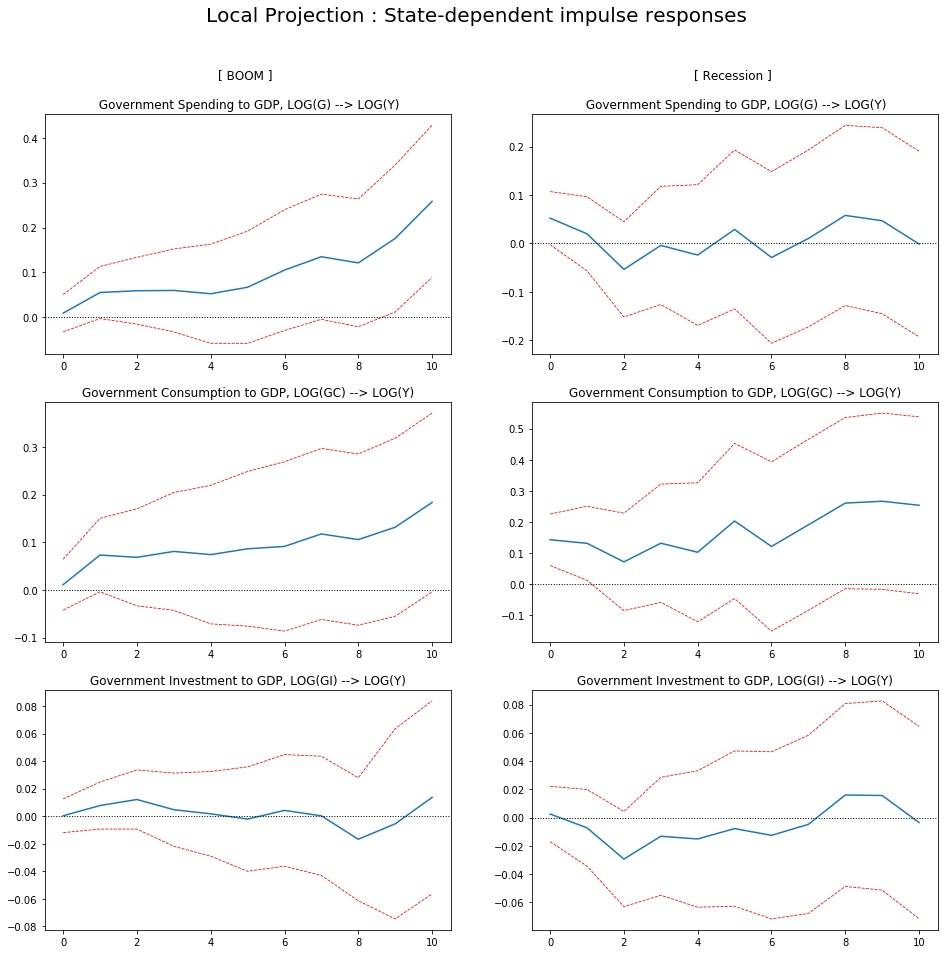

In [24]:
#----------------------------------------------------------
# Graphing of Local Projection impulse responses
#----------------------------------------------------------

fig = plt.figure(figsize=(16,15))
fig.suptitle('Local Projection : State-dependent impulse responses',size=20)
ax1 = fig.add_subplot(3,2,1)
ax2 = fig.add_subplot(3,2,2)
ax3 = fig.add_subplot(3,2,3)
ax4 = fig.add_subplot(3,2,4)
ax5 = fig.add_subplot(3,2,5)
ax6 = fig.add_subplot(3,2,6)

horizon = 11

ax1.plot(lg_coef_boom[:horizon])
ax1.plot((lg_coef_boom + 1.645 * lg_se_boom)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax1.plot((lg_coef_boom - 1.645 * lg_se_boom)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax1.axhline(0, color='black', linestyle=':', linewidth=1)
ax1.set_title('[ BOOM ] \n\n Government Spending to GDP, LOG(G) --> LOG(Y)')

ax2.plot(lg_coef_recession[:horizon])
ax2.plot((lg_coef_recession + 1.645 * lg_se_recession)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax2.plot((lg_coef_recession - 1.645 * lg_se_recession)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax2.axhline(0, color='black', linestyle=':', linewidth=1)
ax2.set_title('[ Recession ] \n\n Government Spending to GDP, LOG(G) --> LOG(Y)')

ax3.plot(lgc_coef_boom[:horizon])
ax3.plot((lgc_coef_boom + 1.645 * lgc_se_boom)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax3.plot((lgc_coef_boom - 1.645 * lgc_se_boom)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax3.axhline(0, color='black', linestyle=':', linewidth=1)
ax3.set_title('Government Consumption to GDP, LOG(GC) --> LOG(Y)')

ax4.plot(lgc_coef_recession[:horizon])
ax4.plot((lgc_coef_recession + 1.645 * lgc_se_recession)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax4.plot((lgc_coef_recession - 1.645 * lgc_se_recession)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax4.axhline(0, color='black', linestyle=':', linewidth=1)
ax4.set_title('Government Consumption to GDP, LOG(GC) --> LOG(Y)')

ax5.plot(lgi_coef_boom[:horizon])
ax5.plot((lgi_coef_boom + 1.645 * lgi_se_boom)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax5.plot((lgi_coef_boom - 1.645 * lgi_se_boom)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax5.axhline(0, color='black', linestyle=':', linewidth=1)
ax5.set_title('Government Investment to GDP, LOG(GI) --> LOG(Y)')

ax6.plot(lgi_coef_recession[:horizon])
ax6.plot((lgi_coef_recession + 1.645 * lgi_se_recession)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax6.plot((lgi_coef_recession - 1.645 * lgi_se_recession)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax6.axhline(0, color='black', linestyle=':', linewidth=1)
ax6.set_title('Government Investment to GDP, LOG(GI) --> LOG(Y)')